In [5]:
import IrisBackendv3 as IB3

In [6]:
IB3.init_from_latest()

2023-03-06 09:36:45 MacBook-Pro.lan IrisBackendv3.data_standards.logging[7710] INFO Successfully Loaded 22 Modules with 75 Commands, 188 Channels, and 68 Events from ./out/DataStandardsCache/IBv3_datastandards_01GTVM50AKJ2AT3DDTP5D9YNE2.dsc .
2023-03-06 09:36:45: INFO     Successfully Loaded 22 Modules with 75 Commands, 188 Channels, and 68 Events from ./out/DataStandardsCache/IBv3_datastandards_01GTVM50AKJ2AT3DDTP5D9YNE2.dsc .


In [2]:
from scripts.testing.ipc_demo.image_builder_demo import *

2023-09-26 16:23:59: INFO     Successfully Loaded 23 Modules with 81 Commands, 188 Channels, and 84 Events from ./out/DataStandardsCache/IBv3_datastandards_01HAD9659G76YQWC7D6BKYAZM6.dsc .
2023-09-26 16:23:59: NOTICE   IRIS Lunar Rover - FileBuilderDemo - IPC App Started
2023-09-26 16:23:59: VERBOSE  Using default binding scheme (`bind=False`) for `socket_type=<SocketType.SUBSCRIBER: 3>`.
2023-09-26 16:23:59: INFO     Created a `SocketType.SUBSCRIBER` connected to `tcp://127.0.0.1` on ports `[<Port.TRANSCEIVER_SUB: 61454>]` (`0xF00E`).
2023-09-26 16:23:59: VERBOSE  Subscribing `sub` to: [<Topic.DL_PAYLOADS: b'\xfe\xee'>] . . .


]0;FileBuilderDemo


In [3]:
image_pickle_file = r'./out/image_file_decodings/img_RC9_9.5.4__FM1_Cam0_Test4__after_off_on_then_grid_then_maybe_off_on__pocari_visible_maybe_if_squint/img_RC9_Test_Img__01H3N5VXH4BF7ND9QYGDPWW6E2__40864.image.pkl'
with open(image_pickle_file, 'rb') as ipf:
    reloaded_img = pickle.load(ipf)

In [4]:
SECTION_SIZE = 1944/8
interp_frames: List[np.ndarray] = []

# Build 7 interpolated images from each of the 7 frames inside the composite image:
for i in range(7):
    print(f"Building Frame {i+1} . . .")
    interp_frames.append(reloaded_img.interim_build(
        interpolate_unknown = True,
        interactive_plot_result = False,
        fg_idx_min = i*SECTION_SIZE,
        fg_idx_max = (i+1)*SECTION_SIZE
    ))

Building Frame 1 . . .
Building Frame 2 . . .
Building Frame 3 . . .
Building Frame 4 . . .
Building Frame 5 . . .
Building Frame 6 . . .
Building Frame 7 . . .


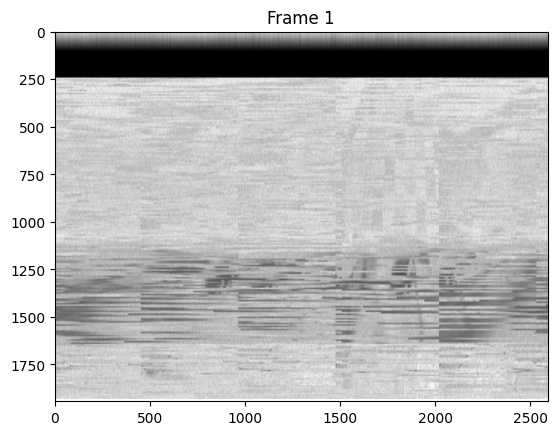

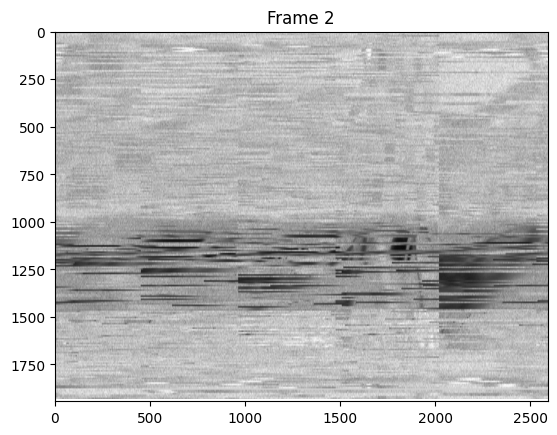

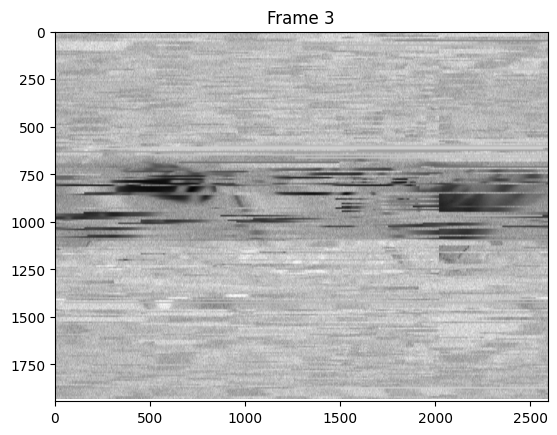

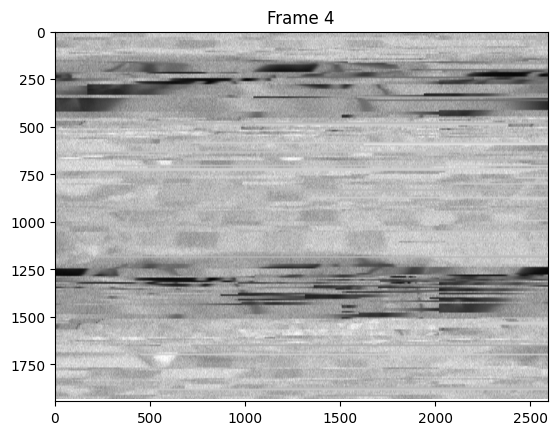

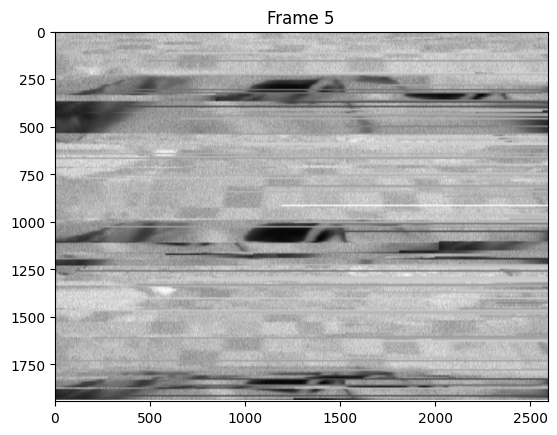

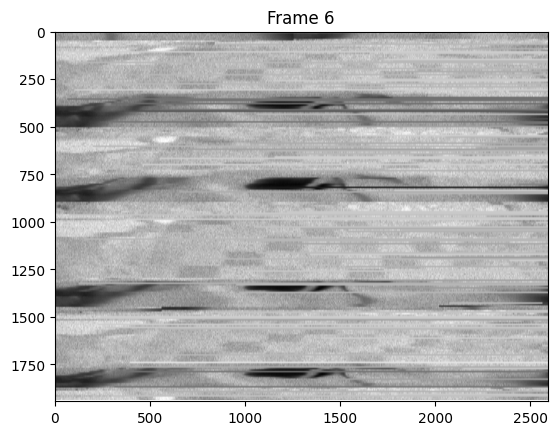

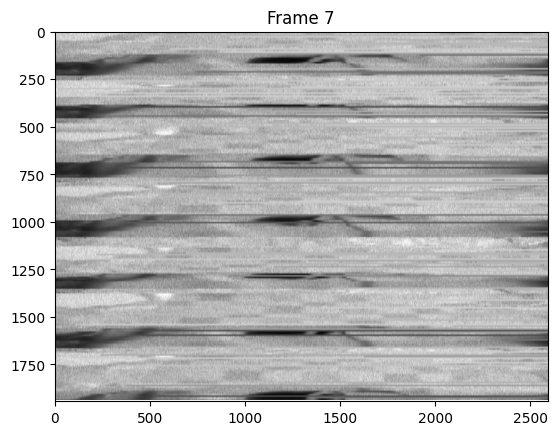

In [5]:
# Display all the frames:
import matplotlib.pyplot as plt
for i, frame in enumerate(interp_frames):
    plt.figure()
    plt.imshow(frame, cmap='gray')
    plt.title(f"Frame {i+1}")
    plt.show()

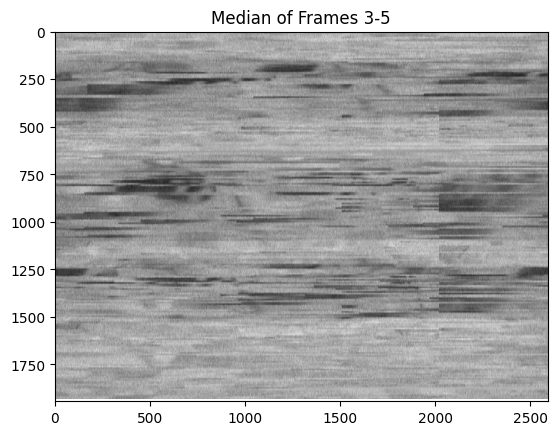

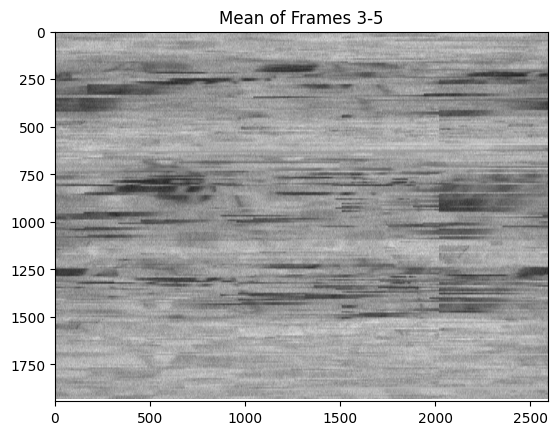

In [6]:
# Display median and mean of all frames up to i:
shape = interp_frames[0].shape
frame_stack = np.vstack([f.reshape(1,shape[0]*shape[1]) for f in interp_frames[2:4]])
median = np.median(frame_stack, axis=0).reshape(*shape)
mean = np.mean(frame_stack, axis=0).reshape(*shape)

plt.figure()
plt.imshow(median, cmap='gray')
plt.title(f"Median of Frames 3-5")
plt.show()
plt.figure()
plt.imshow(mean, cmap='gray')
plt.title(f"Mean of Frames 3-5")
plt.show()

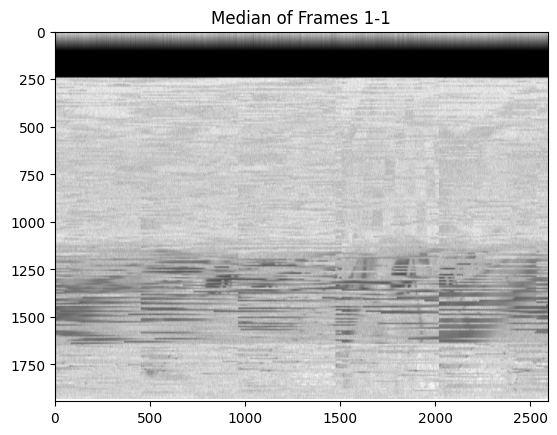

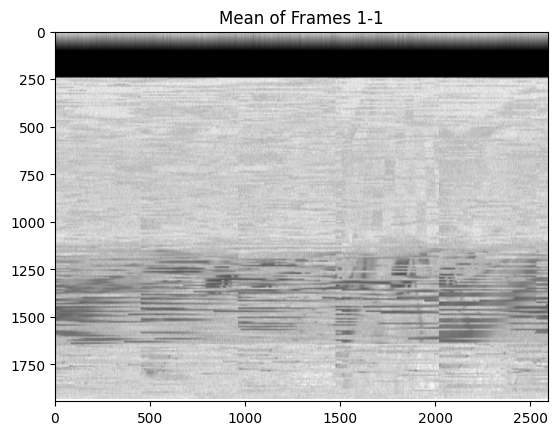

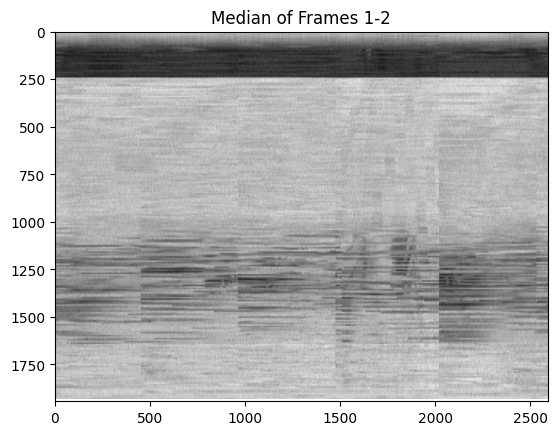

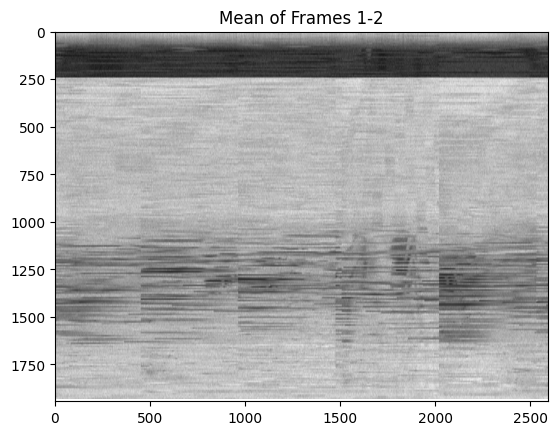

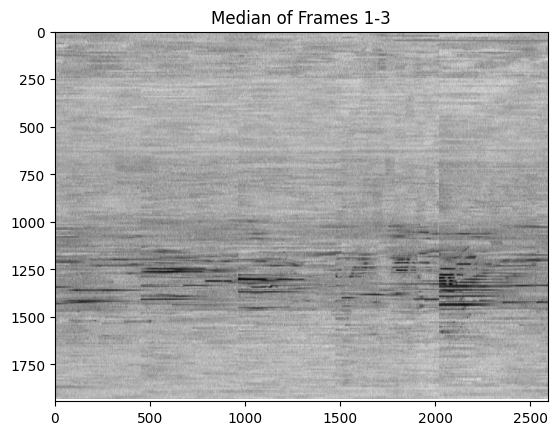

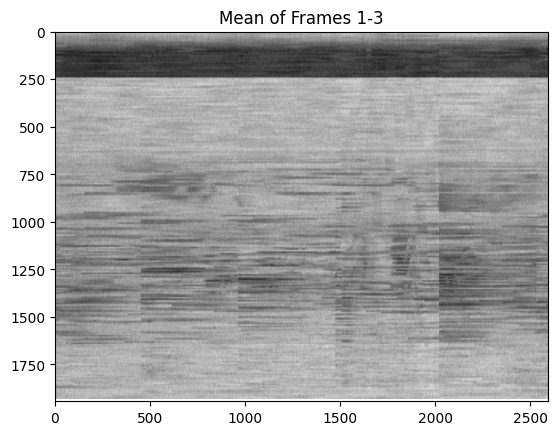

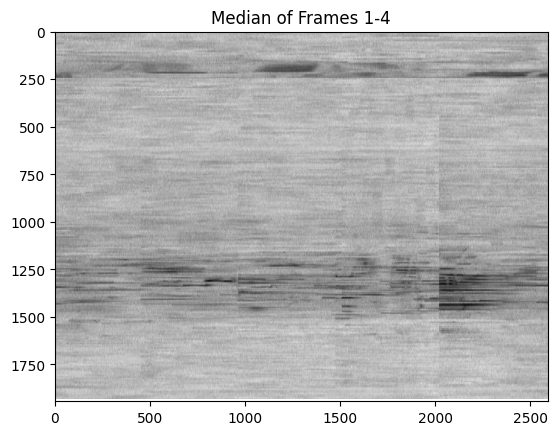

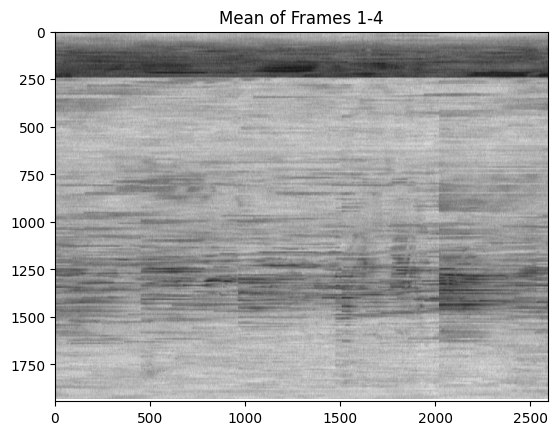

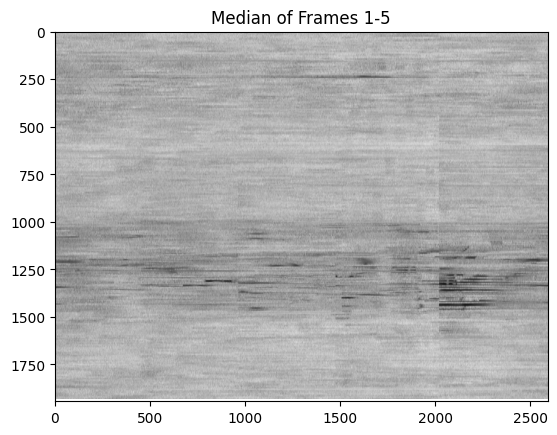

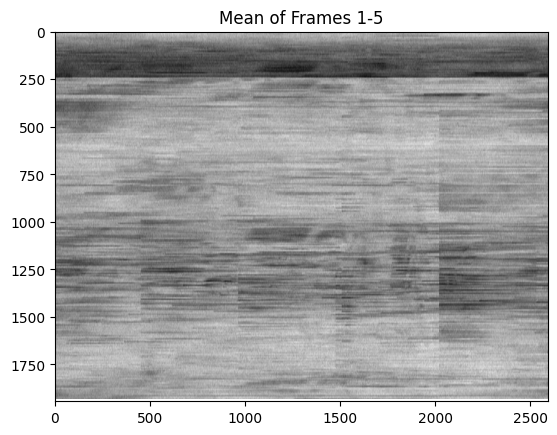

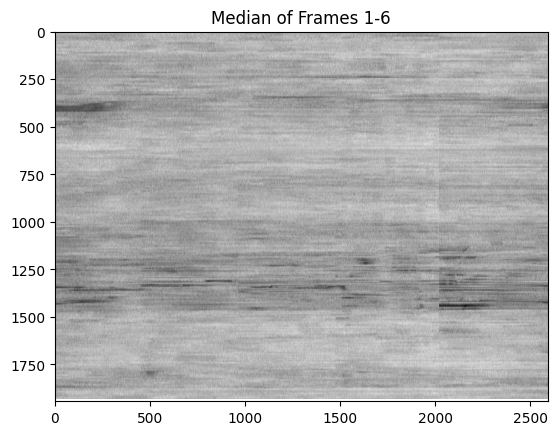

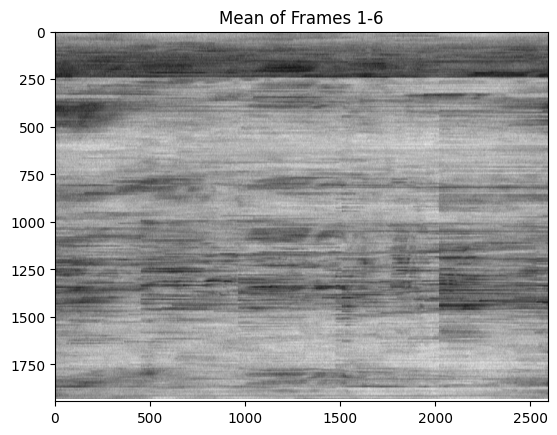

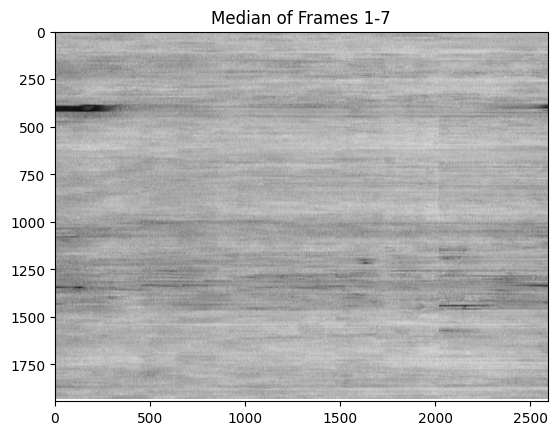

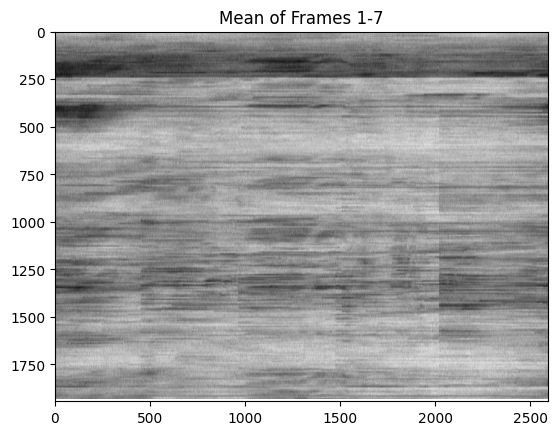

In [7]:
for i in range(len(interp_frames)):
    shape = interp_frames[0].shape
    frame_stack = np.vstack([f.reshape(1,shape[0]*shape[1]) for f in interp_frames[:(i+1)]])
    median = np.median(frame_stack, axis=0).reshape(*shape)
    mean = np.mean(frame_stack, axis=0).reshape(*shape)
    plt.figure()
    plt.imshow(median, cmap='gray')
    plt.title(f"Median of Frames 1-{i+1}")
    plt.show()
    plt.figure()
    plt.imshow(mean, cmap='gray')
    plt.title(f"Mean of Frames 1-{i+1}")
    plt.show()

In [33]:
# Multiple frames appear to be included in each frame (possibly because of false FV and LV readings)...
# We're going to manually determine the boundaries and extract each of those and build more frames:
def extract_subframes(
    frame: np.ndarray,
    subframe_boundaries: List[Tuple[Tuple[int,int], Tuple[int,int]]]
) -> List[np.ndarray]:
    """
    Subframe boundaries is a list of tuple where each tuple contains:
        - A Tuple of the starting and ending row of the subframe
        - A Tuple of the starting and ending col of the subframe
    """
    subframes: List[np.ndarray] = []
    for row_range, col_range in subframe_boundaries:
        cropped = frame[slice(*row_range), slice(*col_range)]
        resized = cv2.resize(cropped, (frame.shape[1],frame.shape[0]), interpolation=cv2.INTER_LINEAR)
        subframes.append(resized)
    return subframes

extracted_subframes = [
    extract_subframes(interp_frames[0], [
        ((250, 1944), (1500, 2000))
    ]),
    extract_subframes(interp_frames[1], [
        ((50, 1944), (1500, 2000))
    ]),
    extract_subframes(interp_frames[3], [
        ((500, 1944), (0, 2592))
    ]),
    extract_subframes(interp_frames[4], [
        ((0, 525), (0, 2592)),
        ((525, 1250), (0, 2592)),
        ((1250, 1944), (0, 2592))
    ]),
    extract_subframes(interp_frames[5], [
        ((50, 490), (0, 2592)),
        ((490, 915), (0, 2592)),
        ((915, 1460), (0, 2592)),
        ((1460, 1944), (0, 2592))
    ]),
    extract_subframes(interp_frames[6], [
        ((0, 250), (0, 2592)),
        ((250, 480), (0, 2592)),
        ((480, 795), (0, 2592)),
        ((795, 1125), (0, 2592)),
        ((1125, 1350), (0, 2592)),
        ((1350, 1718), (0, 2592)),
        ((1718, 1944), (0, 2592))
    ]),
]

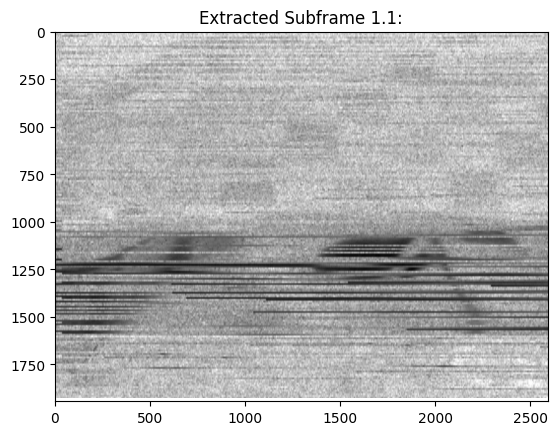

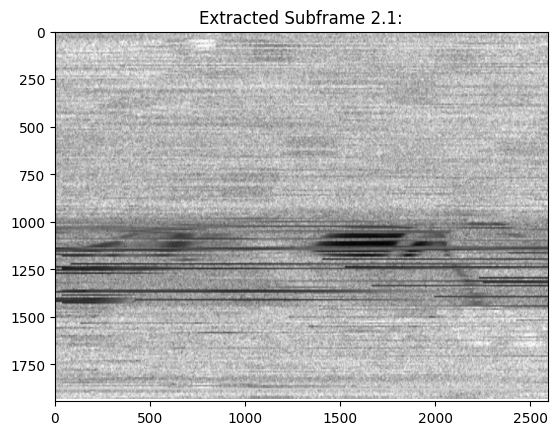

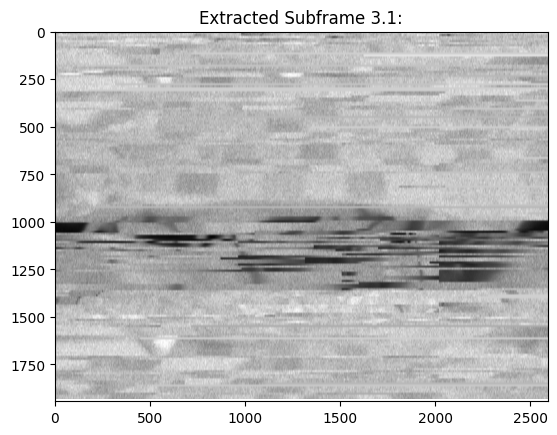

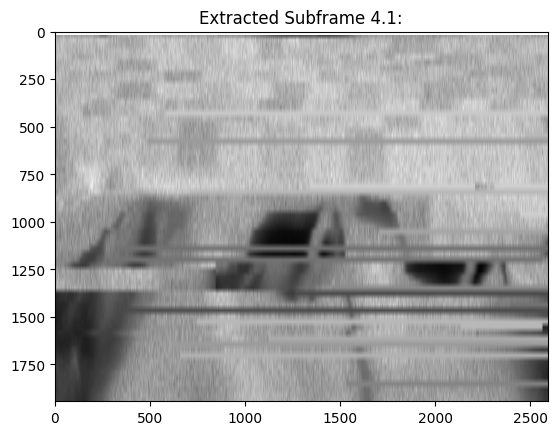

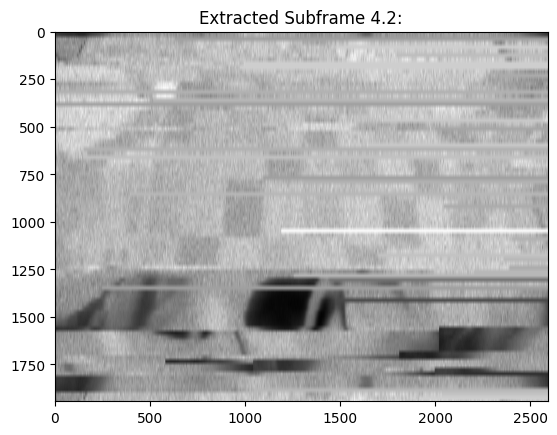

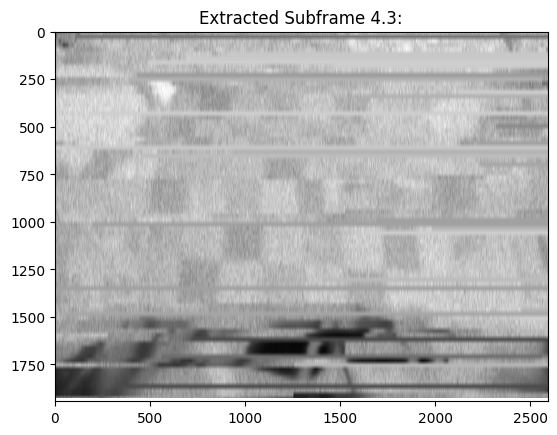

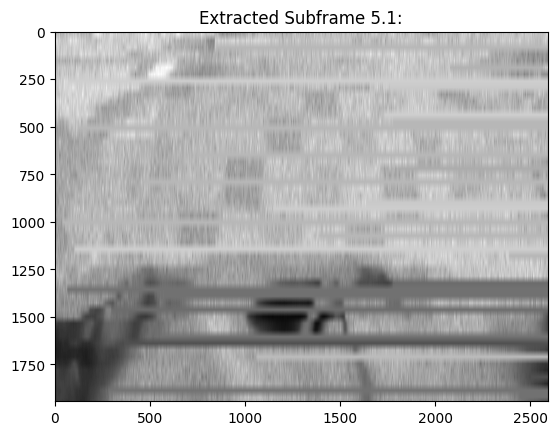

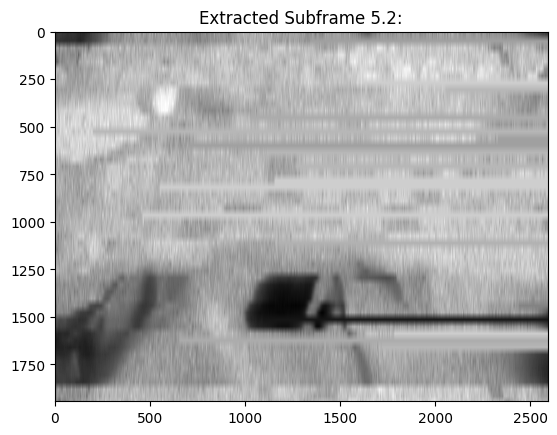

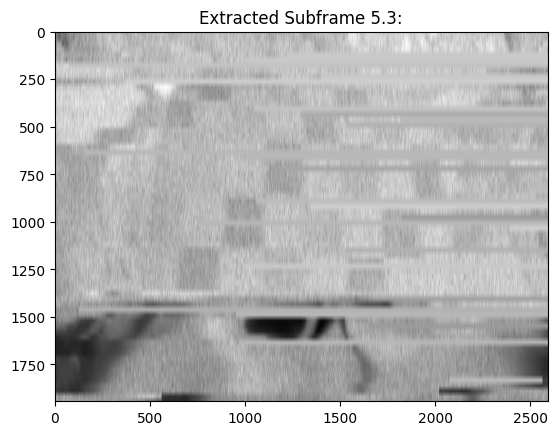

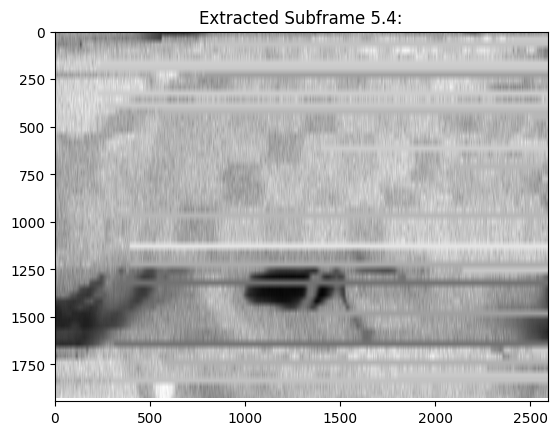

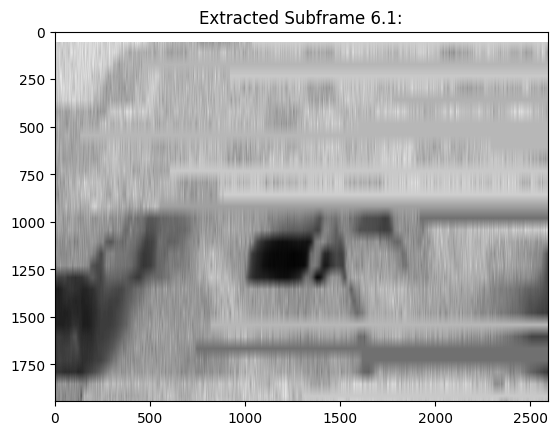

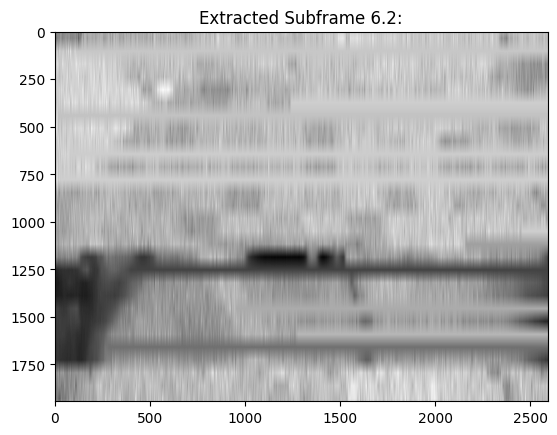

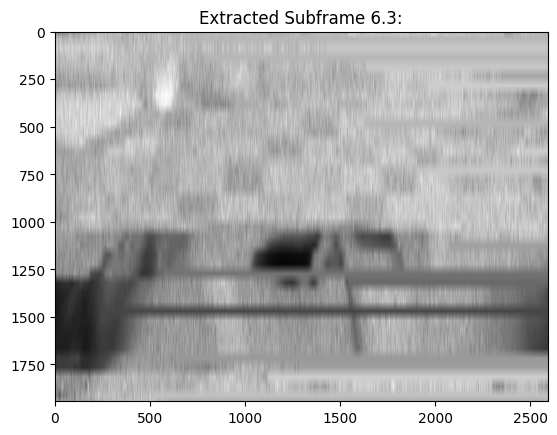

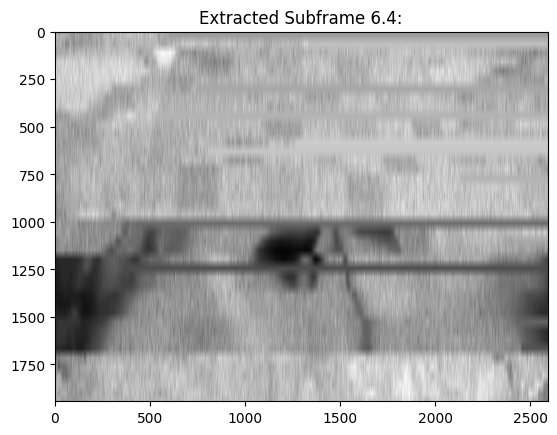

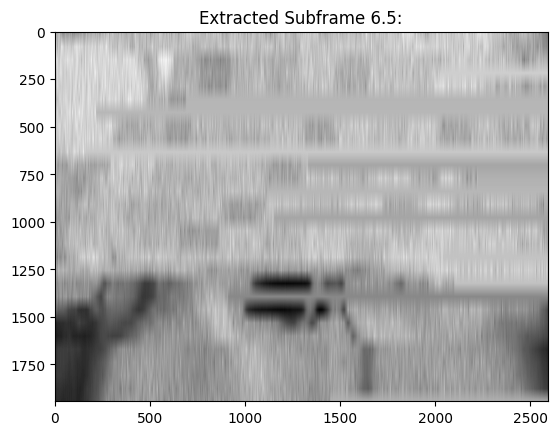

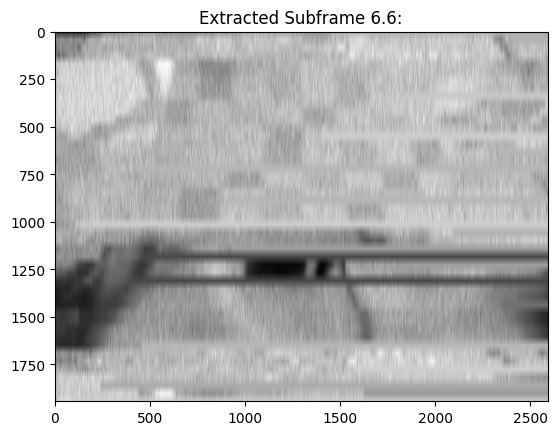

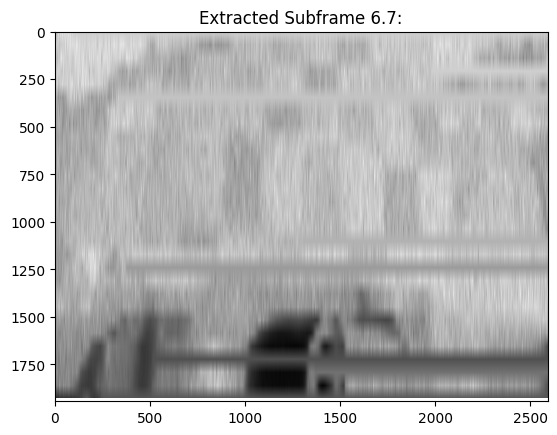

In [34]:
for frame_idx, frame_subframes in enumerate(extracted_subframes):
    for subframe_idx, subframe in enumerate(frame_subframes):
        plt.imshow(subframe, cmap='gray')
        plt.title(f"Extracted Subframe {frame_idx+1}.{subframe_idx+1}:")
        plt.show()

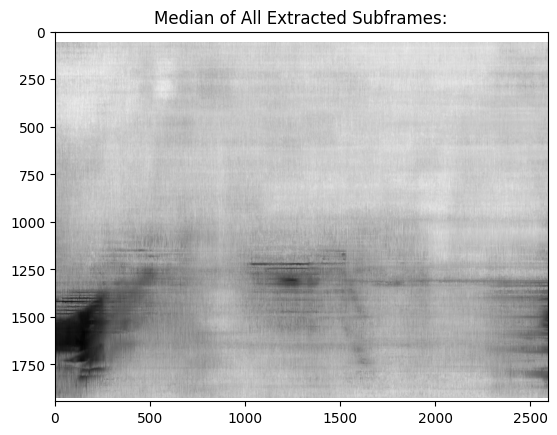

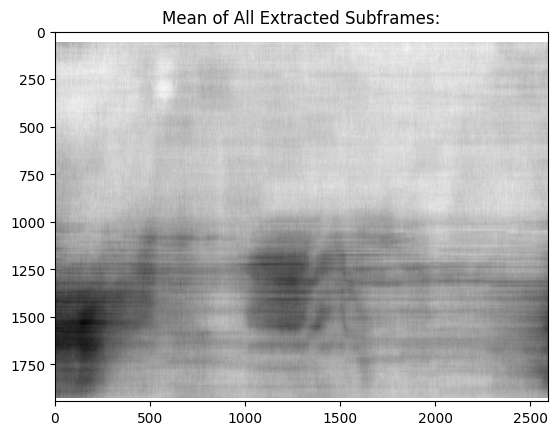

In [36]:
extract_subframes_list = [sf for f in extracted_subframes for sf in f]
shape = extract_subframes_list[0].shape
subframe_stack = np.vstack([sf.reshape(1,shape[0]*shape[1]) for sf in extract_subframes_list])
median = np.median(subframe_stack, axis=0).reshape(*shape)
mean = np.mean(subframe_stack, axis=0).reshape(*shape)
plt.figure()
plt.imshow(median, cmap='gray')
plt.title(f"Median of All Extracted Subframes:")
plt.show()
plt.figure()
plt.imshow(mean, cmap='gray')
plt.title(f"Mean of All Extracted Subframes:")
plt.show()

In [44]:
# Load manually aligned subframes:
IM_DIR = './out/image_file_decodings/RC9_FM1_pic_extracted_frames/aligned_subframes/'
IM_FILES = [f'aligned_subframe_{x}.png' for x in ['4_1', '4_2', '4_3', '5_1', '5_2', '5_3', '5_4', '6_3', '6_4', '6_5', '6_6', '6_7']]
aligned_subframes: List[np.ndarray] = [
    cv2.imread(IM_DIR + imf, cv2.IMREAD_GRAYSCALE) for imf in IM_FILES
]

# Assemble images into a 2D-stack pixelwise:
shape = aligned_subframes[0].shape
subframe_stack = np.vstack([asf.reshape(1,shape[0]*shape[1]) for asf in aligned_subframes])

# Remove pixels that should be transparent (set to exactly 255):
subframe_stack = subframe_stack.astype(np.float32)
subframe_stack[subframe_stack == 255] = np.NaN

# Mean and Median them:
median = np.nanmedian(subframe_stack, axis=0).reshape(*shape)
mean = np.nanmean(subframe_stack, axis=0).reshape(*shape)
plt.figure()
plt.imshow(median, cmap='gray')
plt.title(f"Median of All Manually Aligned Subframes:")
plt.show()
plt.figure()
plt.imshow(mean, cmap='gray')
plt.title(f"Mean of All Manually Aligned Subframes:")
plt.show()

ValueError: cannot reshape array of size 726885 into shape (1,242295)

In [ ]:
xcvr = IB3.transceiver.prebuilts.build_xcvr_by_name(
    'PCAP_18H',
    packetgap = 37000,  # skip first 37000 packets (of 37644)
    fixed_period_ms = 10,
    loop = False,
    log_on_receive = False
)
xcvr

In [11]:
xcvr.begin()

2023-03-06 09:37:38: NOTICE   Beginning `PcapTransceiver`. Loading pcap file with: PcapParseOpts(pcap_file='./test-data/Iris_210503_18_hours_of_telem.pcap', filter_port='any', filter_protocol=None, packetgap=37000, deadspace=0, logging_level='INFO') . . .
2023-03-06 09:37:38: NOTICE   Parsing pcap file at ./test-data/Iris_210503_18_hours_of_telem.pcap, looking for packets on port any .
Subsequent parser status updates will be logged at `INFO` level.
2023-03-06 09:37:38: INFO     	 > Opening pcap . . .
2023-03-06 09:37:45: INFO     	 > Found 37644 packets in pcap.
2023-03-06 09:37:45: INFO     	 > Found 644 packets matching filter criteria.
2023-03-06 09:37:45: INFO     	 > Extracting packets . . .
2023-03-06 09:37:45: INFO     		 > Loaded     1/  644 packets.
2023-03-06 09:37:45: INFO     		 > Loaded   101/  644 packets.
2023-03-06 09:37:45: INFO     		 > Loaded   201/  644 packets.
2023-03-06 09:37:45: INFO     		 > Loaded   301/  644 packets.
2023-03-06 09:37:45: INFO     		 > Loaded

In [12]:
packets = await xcvr.async_read()

2023-03-06 09:37:47 MacBook-Pro.lan IrisBackendv3.codec.logging[7710] WARNING Invalid packet detected. Does not conform to any supported specs: b'\x1eF\xb0p@\x97\xc0\xf4\x01\xfd\x0c<\x004!\x10\x01\x014!'
2023-03-06 09:37:47: WARNING  Invalid packet detected. Does not conform to any supported specs: b'\x1eF\xb0p@\x97\xc0\xf4\x01\xfd\x0c<\x004!\x10\x01\x014!'


In [15]:
from IrisBackendv3.ipc.messages import DownlinkedPacketsMessage, DownlinkedPacketsContent
packets_e = packets[:10]
print(len(packets_e))
dpm = DownlinkedPacketsMessage(DownlinkedPacketsContent(
    packets=packets_e
))
dpmb = dpm.to_ipc_bytes()

10


In [25]:
from IrisBackendv3.ipc.messages import DownlinkedPacketsMessage, DownlinkedPacketsContent
while len(packets := await xcvr.async_read()) != 0:
    dpm = DownlinkedPacketsMessage(DownlinkedPacketsContent(
        packets=packets
    ))

    dpmb = dpm.to_ipc_bytes()
    dpm2 = DownlinkedPacketsMessage.from_ipc_bytes(dpmb)
    print(dpm2)

    assert (dpm == dpm2)

2023-03-06 09:44:07: VERBOSE  `PcapTransceiver` has reached the end of the pcap loaded from `./test-data/Iris_210503_18_hours_of_telem.pcap`.


IPM(content = DownlinkedPacketsContent(packets=[ICP[#173::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#174::612]: 	51 T	- 0 E	- 0 B	- 0 C, MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535, ICP[#175::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#176::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#177::612]: 	51 T	- 0 E	- 0 B	- 0 C, MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535, ICP[#178::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#179::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#180::612]: 	51 T	- 0 E	- 0 B	- 0 C, MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535, ICP[#181::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#182::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#183::612]: 	51 T	- 0 E	- 0 B	- 0 C, MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535, ICP[#184::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#185::612]: 	51 T	- 0 E	- 0 B	- 0 C, ICP[#186::612]: 	51 T	- 0 E	- 0 B	-

In [17]:
packets = await xcvr.async_read()
packets

2023-03-05 15:07:04 MacBook-Pro.lan IrisBackendv3.codec.logging[92832] WARNING Invalid packet detected. Does not conform to any supported specs: b'\x1eF\xb0p@\x97\xc0\xf4\x01\xfd\x0c<\x004!\x10\x01\x014!'
2023-03-05 15:07:04: WARNING  Invalid packet detected. Does not conform to any supported specs: b'\x1eF\xb0p@\x97\xc0\xf4\x01\xfd\x0c<\x004!\x10\x01\x014!'


0


[ICP[#41::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#42::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535,
 ICP[#43::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#44::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#45::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535,
 ICP[#46::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#47::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#48::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535,
 ICP[#49::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#50::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#51::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 MISSION:	[Heat: ON, Ctrl: ON] 	260.9°K -> 273.6°K +- 0.92K° 	Kp = 500 @ Duty Cycle: 8500/65535,
 ICP[#52::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#53::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 ICP[#54::612]: 	51 T	- 0 E	- 0 B	- 0 C,
 MISSION:	[Heat: ON, Ctrl: ON] 	260.9°

In [18]:
from IrisBackendv3.ipc.messages import DownlinkedPacketsMessage, DownlinkedPacketsContent
packets_sub = packets
msg = DownlinkedPacketsMessage(DownlinkedPacketsContent(packets_sub))
msg

IPM(content = DownlinkedPacketsContent(packets=[ICP[#41::612]: 	51 T	- 0 E	- 0 B	- 0 C]))

In [22]:
msgb = msg.to_ipc_bytes()
len(msgb)

5700

In [24]:
msg2 = DownlinkedPacketsMessage.from_ipc_bytes(msgb)
msg2

IPM(content = DownlinkedPacketsContent(packets=[ICP[#41::612]: 	51 T	- 0 E	- 0 B	- 0 C]))

In [25]:
msg == msg2

True

In [14]:
import asyncio

In [15]:
items = [*range(10)]
i: int = 0
period_ms: float = 250
async def read_next():
    global i
    i+=1
    await asyncio.sleep(period_ms/1000)
    return items[i] if i<len(items) else None

In [16]:
while (item := await read_next()) is not None:
    print(item)

1
2
3
4
5
6
7
8
9
